# V928 Tau - Period Analysis

This notebook contains all the steps necessary to check the ground-based survey data for additional eclipses or signs there of (with the same shape as the eclipse detected by <strong>K2</strong>). The work is quite extensive and intensive as we attempt period folding on ~10 years of photometric data from eight ground-based survey telescopes (ASAS, ASAS-SN, ATLAS, CRTS, KELT, PTF, SWASP, ZTF) and four teams of amateurs (Sjoerd Dufoer, Franz-Josef Hambsch, Tonny Vanmunster and the AstroLab Iris team) along with the <strong>K2</strong> data.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from Code import period_analysis as pa
from Code import ground_variation as gv

%matplotlib inline

## Load the Data

First we load all the photometric data, and then remove the stellar variation model from the data.

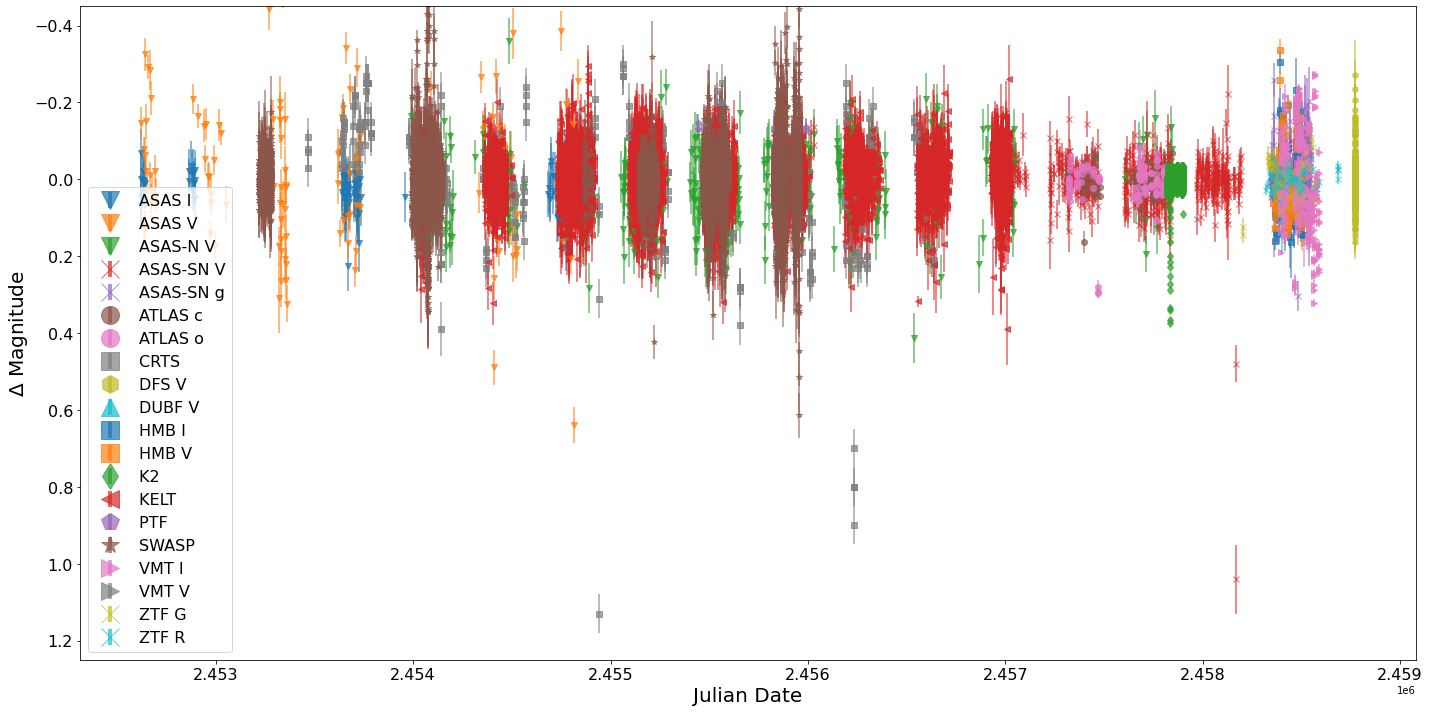

In [2]:
# load the data
times, mags, errors, telescopes = gv.load_survey_data('data/photometry/all_data.txt')

# plot it
gv.plot_all(times, mags, errors, telescopes)

In [3]:
# stellar variation model

# get k2_time0
for i, tel in enumerate(telescopes):
    if 'K2' in tel:
        k2_ind = i
k2_time0 = times[k2_ind][0]

# remove stellar variations from data
pb_sv = np.load('models/best_fits/stellar_variation.npy')
mags_corr = []
for time, mag in zip(times, mags):
    stellar_var = gv.ground_stellar_variation_model(pb_sv, time, k2_time0)
    mags_corr.append(mag - stellar_var)

## Period Folding $-$ Preparation

Here we do the actual period folding and do some of the preparations necessary for it, like extracting K2 data from the rest, running a trial and then doing the period folding and making and saving the plots to be explored by hand.

### Extract K2 data and limits

In [4]:
# separate k2 from ground based data
ground_times = []
ground_mags = []
ground_errors = []
ground_tels = []
for time, mag, error, telescope in zip(times, mags_corr, errors, telescopes):
    if 'K2' in telescope:
        k2_time = time
        k2_mag = mag
        k2_error = error
    else:
        ground_times.append(time)
        ground_mags.append(mag)
        ground_errors.append(error)
        ground_tels.append(telescope)


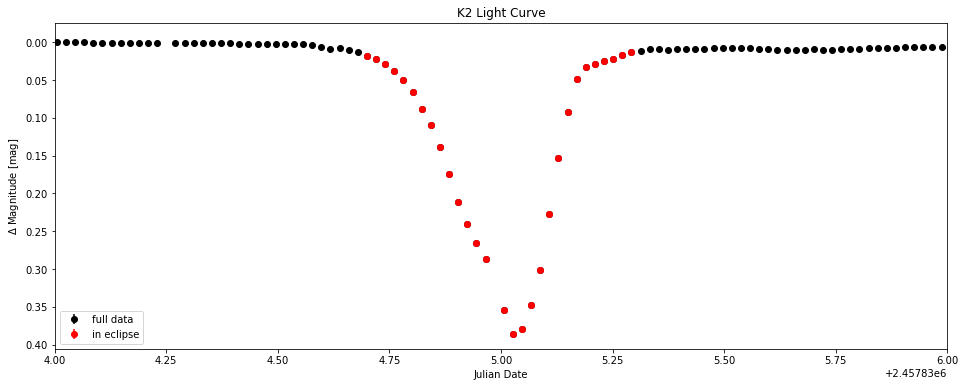

In [5]:
# get the eclipse
k2l = 681
k2u = 710
k2te = k2_time[k2l:k2u]
k2me = k2_mag[k2l:k2u]
k2ee = k2_error[k2l:k2u]

fig = plt.figure(figsize=(16, 6))
plt.errorbar(k2_time, k2_mag, yerr=k2_error, fmt='o', color='k', label='full data')
plt.errorbar(k2te, k2me, yerr=k2ee, fmt='o', color='r', label='in eclipse')
plt.legend()
plt.title('K2 Light Curve')
plt.xlabel('Julian Date')
plt.ylabel('$\Delta$ Magnitude [mag]')
plt.gca().invert_yaxis()
plt.xlim(2457834, 2457836)
plt.show()

### Test

This is just to ensure everything is working and give a feel for what the goal is of the period folding.

In [6]:
# do a test
period = 138.2
k2l = 681
k2u = 710
good_pct = 90
sigma = 1
plot_data, total, percentage, chi2s, tot_chi2 = pa.prepare_data(period, k2_time, k2_mag, k2_error, ground_times, ground_mags, ground_errors, k2l, k2u, sigma)

/Users/dmvandam/SurfDrive/phd/repositories/v928tau/Code/period_analysis.py:239: RuntimeWarning: invalid value encountered in double_scalars
  chi2s.append(chi2 / num)


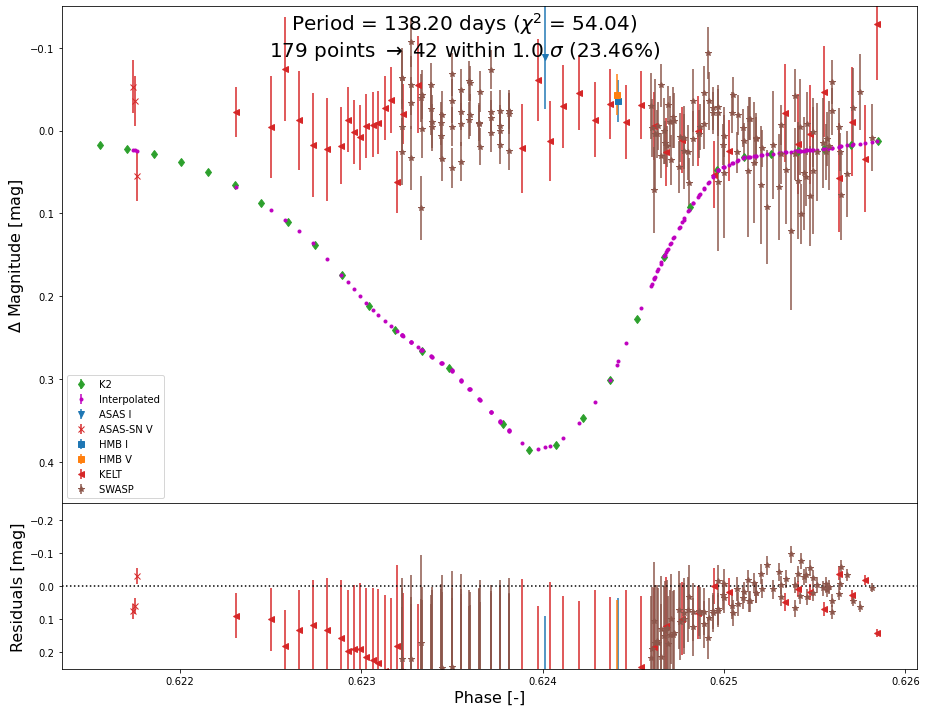

In [7]:
title_str = 'Period = %.2f days ($\chi^2$ = %.2f)\n%i points $\\rightarrow$ %i within %.1f $\sigma$ (%.2f%%)'
title = title_str % (period, tot_chi2, total, percentage*total/100, sigma, percentage)
pa.plot_folded_eclipse(*plot_data, ground_tels, title=title, ylim1=(-0.15,0.45),ylim2=(-0.25,0.25))

## Period Folding $-$ Performing

Here we commit to the actual period folding itself. We know from the orbital analysis notebook that the period is limited between 66 days and $\sim$1200 days, so we choose this range, and choose a fine grid to test whether or not the period folding fulfills certain requirements.
- percentage of good points > outlier acceptance
    - good points lie within x times the error bar
    - outlier acceptance percentage is an input value
- we require there to be some data folded in
    - the number can be tuned

In [8]:
# folding periods in days
Pmin = 66    # min
Pmax = 1200  # max
dP   = 0.002 # step size

# combine
P = np.arange(Pmin, Pmax + dP, dP)

In [9]:
# combining standard parameters
k2_params = (k2_time, k2_mag, k2_error)
ground_params = (ground_times, ground_mags, ground_errors, ground_tels)

In [10]:
# plot parameters
xlim   = None
ylim1  = (-0.15, 0.45)
ylim2  = (-0.25, 0.25)
k2_ind = 12
show   = False

# combine
plot_params = (xlim, ylim1, ylim2, k2_ind, show)

In [11]:
# defining parameters
k2_tl      = 681
k2_tu      = 710
good_pct   = 90
min_points = 5

### Unbinned Photometry

sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [16]:
# combine
plot_selection_20 = (k2_tl, k2_tu, 2.0, good_pct, min_points)
full_params_20 = (*k2_params, *ground_params, *plot_selection_20, *plot_params)

# folding and extracting
p_s20 = pa.fold_all(P, *full_params_20)

text file exists -- done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [17]:
# combine
plot_selection_15 = (k2_tl, k2_tu, 1.5, good_pct, min_points)
full_params_15 = (*k2_params, *ground_params, *plot_selection_15, *plot_params)

# folding and extracting
p_s15 = pa.fold_all(p_s20, *full_params_15)

text file exists -- done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [18]:
# combine
plot_selection_10 = (k2_tl, k2_tu, 1.0, good_pct, min_points)
full_params_10 = (*k2_params, *ground_params, *plot_selection_10, *plot_params)

# folding
p_s10 = pa.fold_all(P, *full_params_10)

text file exists -- done


### Binned Photometry (0.1 day = 2.4 hours)

Here we explore the period folding, but also add the fact that the data is binned (0.1 day bins). We bin each telescope (except <strong>K2</strong>) and then repeat the process above.

In [19]:
binsize = 0.1
sr_01b = 'plots/period_folding/sigma=%.1f_bs=0.10/'

# set-up lists
binned_times  = []
binned_mags   = []
binned_errors = []

for time, mag, error in zip(ground_times, ground_mags, ground_errors):
    # calculate
    binned_time, binned_mag, binned_error = gv.bin_telescope(time, mag, error, binsize)
    # append
    binned_times.append(binned_time)
    binned_mags.append(binned_mag)
    binned_errors.append(binned_error)

binned_params = (binned_times, binned_mags, binned_errors, ground_tels)

sigma = 3.0, good_percentage = 90 % and min_points = 5.

In [20]:
plot_selection_30 = (k2_tl, k2_tu, 3.0, good_pct, min_points)

# combine
full_params_30b = (*k2_params, *binned_params, *plot_selection_30, *plot_params)

# fold and extract
p_s30b = pa.fold_all(P, *full_params_30b, saveroot=sr_01b)

text file exists -- done


sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [23]:
# combine
full_params_20b = (*k2_params, *binned_params, *plot_selection_20, *plot_params)

# fold and extract
p_s20b = pa.fold_all(p_s30b, *full_params_20b, saveroot=sr_01b)

text file exists -- done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [25]:
# combine
full_params_15b = (*k2_params, *binned_params, *plot_selection_15, *plot_params)

# fold and extract
p_s15b = pa.fold_all(p_s20b, *full_params_15b, saveroot=sr_01b)

text file exists -- done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [27]:
# combine
full_params_10b = (*k2_params, *binned_params, *plot_selection_10, *plot_params)

# fold and extract
p_s10b = pa.fold_all(p_s15b, *full_params_10b, saveroot=sr_01b)

text file exists -- done


### Binned Photometry (0.05 day $\sim$ 1 hours)

Here we explore the period folding, but also add the fact that the data is binned (0.05 day bins). We bin each telescope (except <strong>K2</strong>) and then repeat the process above.

In [28]:
binsize = 0.05
sr_005b = 'plots/period_folding/sigma=%.1f_bs=0.05/'

# set-up lists
binned_times  = []
binned_mags   = []
binned_errors = []

for time, mag, error in zip(ground_times, ground_mags, ground_errors):
    # calculate
    binned_time, binned_mag, binned_error = gv.bin_telescope(time, mag, error, binsize)
    # append
    binned_times.append(binned_time)
    binned_mags.append(binned_mag)
    binned_errors.append(binned_error)

binned_params = (binned_times, binned_mags, binned_errors, ground_tels)

sigma = 3.0, good_percentage = 90 % and min_points = 5.

In [29]:
# fold and extract
p_s30b2 = pa.fold_all(P, *full_params_30b, saveroot=sr_005b)

text file exists -- done


sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [30]:
# fold and extract
p_s20b2 = pa.fold_all(p_s30b2, *full_params_20b, saveroot=sr_005b)

text file exists -- done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [33]:
# fold and extract
p_s15b2 = pa.fold_all(p_s20b2, *full_params_15b, saveroot=sr_005b)

text file exists -- done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [35]:
# fold
p_s10b2 = pa.fold_all(p_s15b2, *full_params_10b, saveroot=sr_005b)

text file exists -- done
